In [1]:
import numpy as np 
import pandas as pd
from scipy import fft
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt 
from scipy.signal import periodogram
from matplotlib.ticker import FuncFormatter 
from matplotlib.ticker import MultipleLocator
FuncFormatter

matplotlib.ticker.FuncFormatter

In [2]:
# Membaca data
df = pd.read_excel('QBO Data.xlsx')

# Menampilkan DataFrame
print(df)

     30 hPa  25 hPa  20 hPa     Date
0      -260    -289    -326  1011987
1      -266    -280    -307  1021987
2      -271    -309    -311  1031987
3      -270    -303    -328  1041987
4      -268    -289    -295  1051987
..      ...     ...     ...      ...
414    -238    -297    -316  1072021
415    -233    -319    -330  1082021
416    -268    -332    -359  1092021
417    -283    -339    -368  1102021
418    -279    -320    -351  1112021

[419 rows x 4 columns]


In [3]:
# Membaca data
df2 = pd.read_excel('Total Column Ozone.xlsx')

# Menampilkan DataFrame
print(df2)

# Ambil nilai ozon sebagai array
ozon = df2['TCO'].values

        Date      tco   TCO
0    1011987  0.00515  5.15
1    1021987  0.00502  5.02
2    1031987  0.00513  5.13
3    1041987  0.00518  5.18
4    1051987  0.00520  5.20
..       ...      ...   ...
415  1082021  0.00558  5.58
416  1092021  0.00564  5.64
417  1102021  0.00563  5.63
418  1112021  0.00552  5.52
419  1122021  0.00551  5.51

[420 rows x 3 columns]


C:\Users\HP\AppData\Local\Temp\ipykernel_24352\2390673358.py:30: RuntimeWarning: divide by zero encountered in divide
  period = 1 / freqs


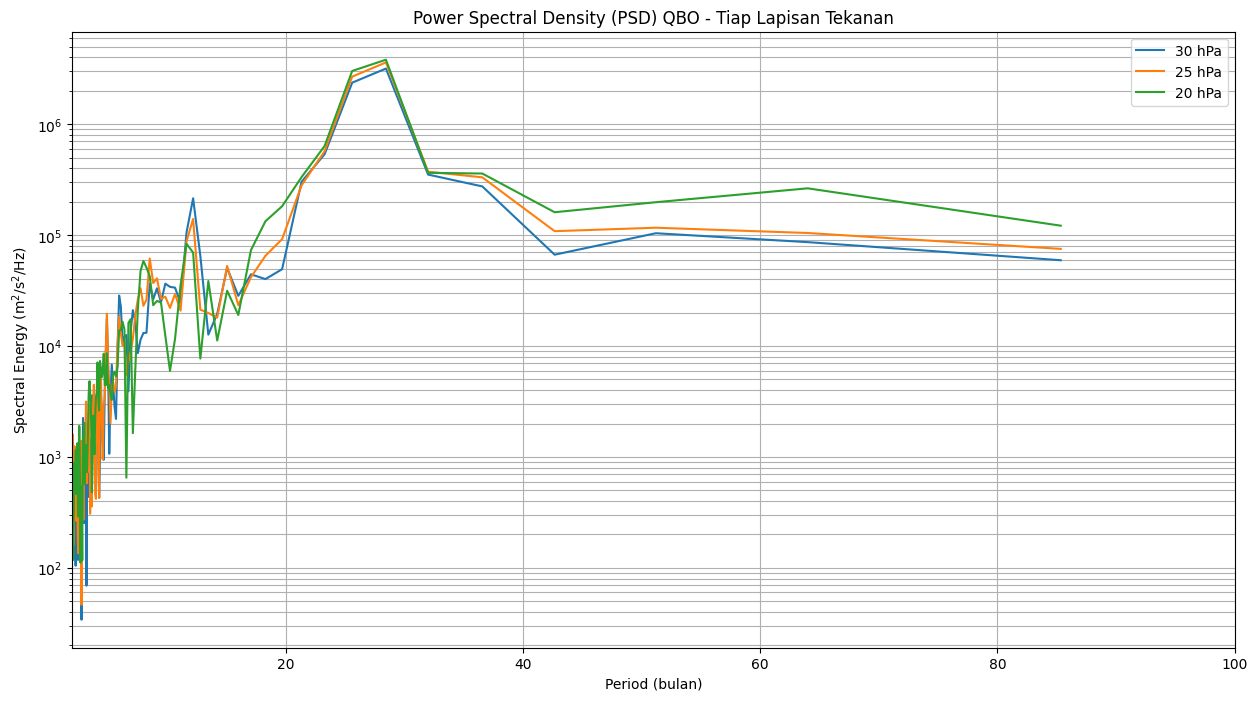


Lapisan dengan komponen spektral paling dominan (berdasarkan PSD):
  Lapisan   PSD Dominan  Periode Dominan (bulan)
2  20 hPa  3.817451e+06                28.444444
1  25 hPa  3.609306e+06                28.444444
0  30 hPa  3.176919e+06                28.444444


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 1. Load data
file_path = "QBO Data.xlsx"
df = pd.read_excel(file_path)

# Pastikan kolom 'Date' jadi index waktu
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop kolom Year dan Month jika masih ada
df = df.drop(columns=['Year', 'Month'], errors='ignore')

# 2. Analisis Power Spectral Density (PSD)
plt.figure(figsize=(15, 8))
dominant_psd = {}
dominant_periods = {}

fs = 1  # Data bulanan, fs = 1/bln

for column in df.columns:
    signal = df[column].dropna().values
    nperseg = min(256, len(signal))
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg, scaling='density')
    
    # Periode (bulan)
    period = 1 / freqs
    # Filter agar period masuk range wajar (2-100 bulan)
    mask = (period > 2) & (period < 100)
    
    # Simpan puncak dominan (selain frekuensi terendah)
    max_index = np.argmax(psd[mask])
    dominant_psd[column] = psd[mask][max_index]
    dominant_periods[column] = period[mask][max_index]

    # Plot
    plt.plot(period[mask], psd[mask], label=f"{column}")

plt.xlabel("Period (bulan)")
plt.ylabel(r"Spectral Energy (m$^2$/s$^2$/Hz)")
plt.title("Power Spectral Density (PSD) QBO - Tiap Lapisan Tekanan")
plt.legend()
plt.grid(True, which='both')
plt.yscale('log')  # Agar nilai tidak terlalu besar, sesuai contoh literatur
plt.xlim(2, 100)
plt.show()

# 3. Ringkasan hasil dominan
dominant_df = pd.DataFrame({
    "Lapisan": dominant_psd.keys(),
    "PSD Dominan": dominant_psd.values(),
    "Periode Dominan (bulan)": dominant_periods.values()
}).sort_values(by="PSD Dominan", ascending=False)

print("\nLapisan dengan komponen spektral paling dominan (berdasarkan PSD):")
print(dominant_df)

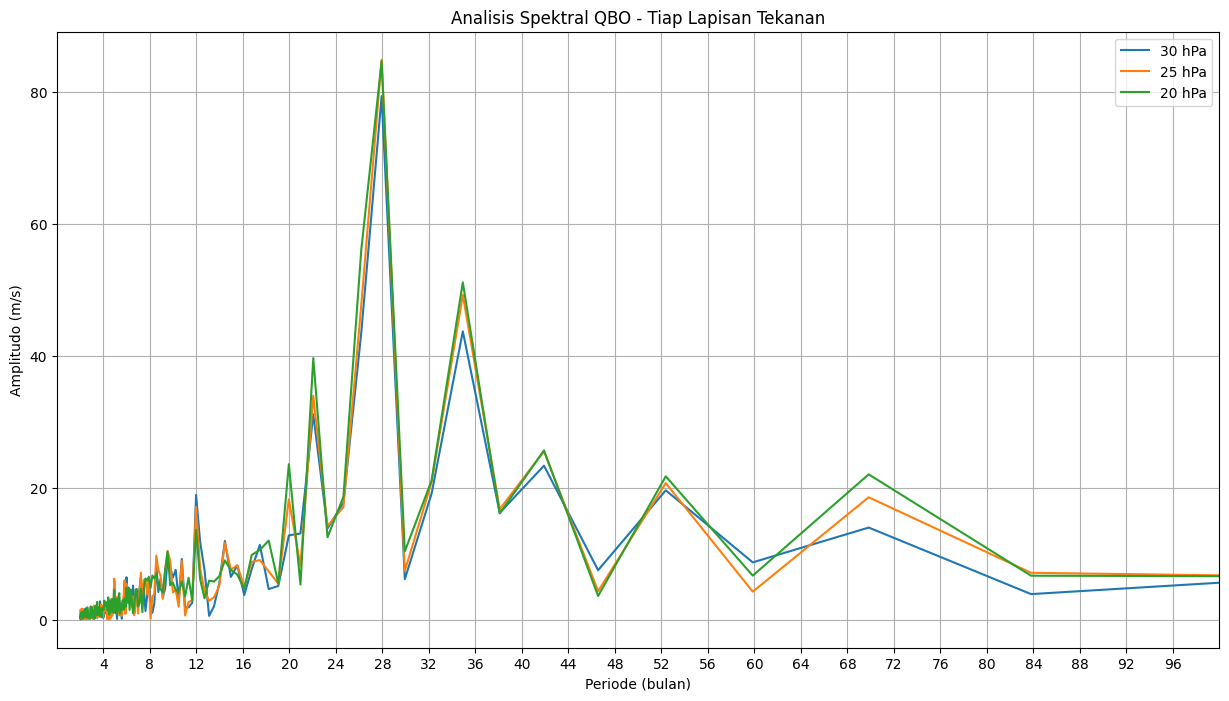


Lapisan dengan komponen spektral paling dominan:
  Lapisan  Amplitudo Dominan  Periode Dominan (bulan)
1  25 hPa          84.914368                27.933333
2  20 hPa          84.687375                27.933333
0  30 hPa          79.403170                27.933333


In [7]:
# 1. Load data
file_path = "QBO Data.xlsx"
df = pd.read_excel(file_path)

# Pastikan kolom 'Date' jadi index waktu
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop kolom Year dan Month jika masih ada
df = df.drop(columns=['Year', 'Month'], errors='ignore')

# 2. Lakukan FFT pada masing-masing lapisan tekanan
plt.figure(figsize=(15, 8))
dominant_amplitudes = {}
dominant_periods = {}

for column in df.columns:
    signal = df[column].dropna()
    n = len(signal)
    timestep = 1  # diasumsikan data bulanan
    freq = fftfreq(n, d=timestep)
    fft_values = fft(signal) / n  # Normalisasi oleh jumlah data
    
    # Ambil hanya frekuensi positif
    positive_freqs = freq[:n // 2]
    magnitude = np.abs(fft_values[:n // 2])  # Ambil frekuensi positif

    # Simpan data spektrum dominan
    max_index = np.argmax(magnitude[1:]) + 1  # skip frekuensi 0
    dominant_freq = positive_freqs[max_index]
    dominant_period = 1 / dominant_freq if dominant_freq != 0 else np.nan
    dominant_amplitudes[column] = magnitude[max_index]
    dominant_periods[column] = dominant_period

    # Plot spektrum
    plt.plot(1 / positive_freqs[1:], magnitude[1:], label=f"{column}")

# Menyesuaikan sumbu periode ke kelipatan 4
plt.xticks(np.arange(4, 100, 4))

plt.xlabel("Periode (bulan)")
plt.ylabel("Amplitudo (m/s)")
plt.title("Analisis Spektral QBO - Tiap Lapisan Tekanan")
plt.legend()
plt.grid(True)
plt.xlim(0, 100)
plt.show()

# 3. Ringkasan hasil dominan
dominant_df = pd.DataFrame({
    "Lapisan": dominant_amplitudes.keys(),
    "Amplitudo Dominan": dominant_amplitudes.values(),
    "Periode Dominan (bulan)": dominant_periods.values()
}).sort_values(by="Amplitudo Dominan", ascending=False)

print("\nLapisan dengan komponen spektral paling dominan:")
print(dominant_df)

Energi Tertinggi (PSD Maks): 2.3398689328124305
Frekuensi Dominan: 0.002380952380952381 siklus/bulan
Periode Dominan: 420.00 bulan


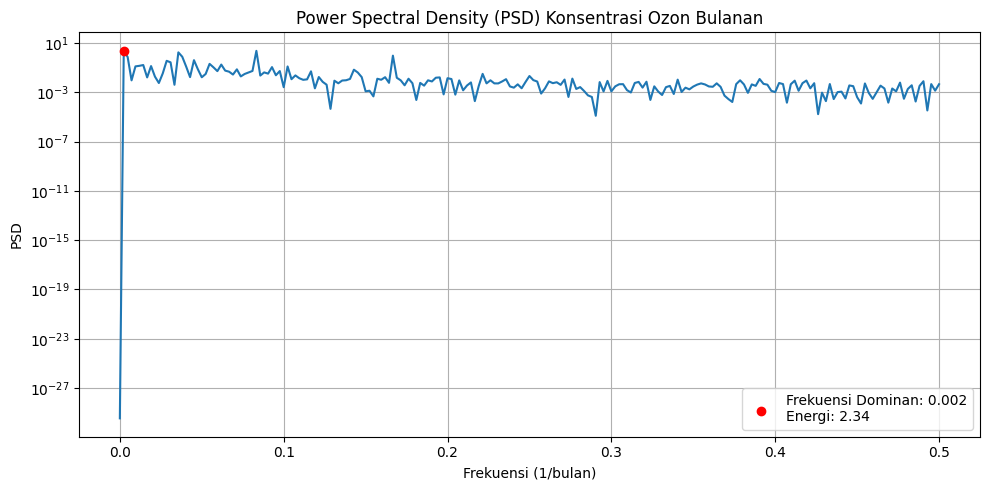

In [10]:
fs = 1  # Sampling 1 per bulan
freqs, psd = periodogram(ozon, fs=fs)

# Temukan energi tertinggi dan frekuensi dominan
idx_max = np.argmax(psd)
energi_tertinggi = psd[idx_max]
frekuensi_dominan = freqs[idx_max]

# Tampilkan hasil
print(f"Energi Tertinggi (PSD Maks): {energi_tertinggi}")
print(f"Frekuensi Dominan: {frekuensi_dominan} siklus/bulan")
if frekuensi_dominan != 0:
    print(f"Periode Dominan: {1/frekuensi_dominan:.2f} bulan")
else:
    print("Periode Dominan: Tak hingga (komponen DC)")

# Visualisasi PSD dan frekuensi dominan
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd)
plt.scatter(
    frekuensi_dominan, energi_tertinggi,
    color='red', zorder=5,
    label=f'Frekuensi Dominan: {frekuensi_dominan:.3f}\nEnergi: {energi_tertinggi:.2f}'
)
plt.title('Power Spectral Density (PSD) Konsentrasi Ozon Bulanan')
plt.xlabel('Frekuensi (1/bulan)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()